# DA5401 A6: Imputation via Regression for Missing Data 

### 🧾 Introduction

This notebook explores **two imputation strategies** for handling missing data:

1. **Using `df_missing`** – where *Missing At Random (MAR)* values were introduced in multiple columns.  
2. **Using `df_original`** – where missing values were artificially introduced only in the **`AGE`** column for a controlled single-column imputation experiment.

 **Note:**  
Each imputation section in this notebook is divided into **two parts**:  
- **Approach 1:** Based on `df_original` (single-column imputation).  
- **Approach 2:** Based on `df_missing` (multi-column MAR imputation). 

In [449]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import (
    classification_report,
    precision_recall_curve,
    roc_curve,
    auc,
    average_precision_score
)
import warnings
warnings.filterwarnings("ignore")

random_state=42

In [450]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

### Part A.1: Load and Prepare Data

In [451]:
df =pd.read_csv("UCI_Credit_Card.csv")
print("Shape of dataset:", df.shape)
df.head()

Shape of dataset: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [452]:
# Check if any duplicate rows exist
duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [453]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [454]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
object_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Object columns:", object_cols)
print(f"\nTotal numeric columns: {len(numeric_cols)}")
print(f"Total object columns: {len(object_cols)}")


Numeric columns: ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default.payment.next.month']
Object columns: []

Total numeric columns: 25
Total object columns: 0


In [455]:
# Calculate the total number of missing (NaN) values in each column
missing_summary = df.isnull().sum()

# Filter to include only those columns that actually have missing values
missing_summary = missing_summary[missing_summary > 0]

# Display the names of columns with missing values and their corresponding counts
print("Columns with missing values:\n", missing_summary)


Columns with missing values:
 Series([], dtype: int64)


In [456]:
df[numeric_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
ID,30000.0,15000.500000,8660.398374,1.0,7500.75,15000.5,22500.25,30000.0
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0


In [457]:

# Create the profile report
profile = ProfileReport(
    df,
    title="Credit Default Dataset Profile",
    explorative=True
)
# Save the profiling report as a standalone HTML file
output_path = "credit_profile_report.html"
profile.to_file(output_path)

print(f"✅ Profile report successfully generated and saved as '{output_path}'")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 211.64it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

✅ Profile report successfully generated and saved as 'credit_profile_report.html'


### Missing Values Addition

In [458]:
# Copy the original dataset to avoid modifying df
df_missing = df.copy()

rng = np.random.default_rng(42)  # for reproducibility

# Define target columns and their missingness percentages
cols_to_mask = {
    'AGE': 0.10,        # 10% missing
    'BILL_AMT1': 0.08,  # 8% missing
    'PAY_AMT1': 0.08    # 8% missing
}

# Introduce missingness randomly
for col, frac in cols_to_mask.items():
    missing_indices = df_missing.sample(frac=frac, random_state=42).index
    df_missing.loc[missing_indices, col] = np.nan


In [459]:
missing_summary = df_missing[['AGE', 'BILL_AMT1', 'PAY_AMT1']].isnull().sum()
print("Missing values introduced:")
print(missing_summary)


Missing values introduced:
AGE          3000
BILL_AMT1    2400
PAY_AMT1     2400
dtype: int64


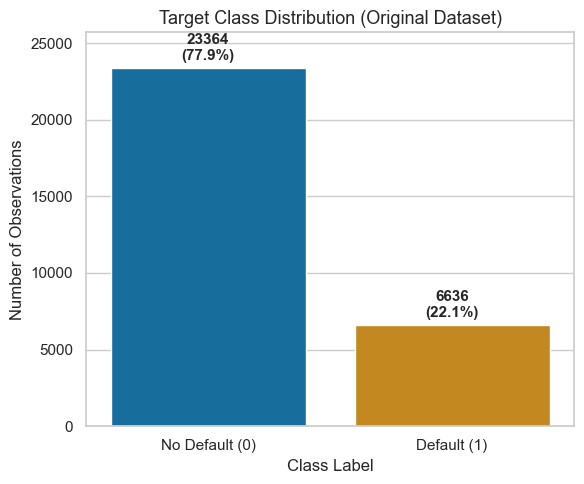

In [460]:
# Count of each target class (0 = no default, 1 = default)
target_counts = df['default.payment.next.month'].value_counts().sort_index()

# Convert to percentage
target_percent = target_counts / target_counts.sum() * 100

# Prepare DataFrame for plotting
target_df = pd.DataFrame({
    'Class': ['No Default (0)', 'Default (1)'],
    'Count': target_counts.values,
    'Percentage': target_percent.values
})

# Plot
sns.set(style="whitegrid", palette="colorblind")

plt.figure(figsize=(6,5))
ax = sns.barplot(data=target_df, x='Class', y='Count', hue='Class', dodge=False)
plt.title('Target Class Distribution (Original Dataset)', fontsize=13)
plt.ylabel('Number of Observations')
plt.xlabel('Class Label')
plt.ylim(0, target_df['Count'].max() * 1.1)

# Annotate bar values with counts and percentages
for i, row in target_df.iterrows():
    ax.text(i, row['Count'] + 500, f"{int(row['Count'])}\n({row['Percentage']:.1f}%)",
            ha='center', fontsize=11, fontweight='bold')

plt.legend([],[], frameon=False)  # hide legend for cleaner look
plt.tight_layout()
plt.show()


#### 🔍 Observations: Target Class Distribution

- The dataset is **highly imbalanced**, with about **77.9% non-default (Class 0)** and **22.1% default (Class 1)** cases.  
- This imbalance implies that models might naturally favor predicting the majority “No Default” class.  
- Hence, **PR-AUC** and **class-weighted models** are more suitable performance measures than accuracy.


In [461]:
missing_summary = pd.DataFrame({
    'Missing_Count_Original': df.isnull().sum(),
    'Missing_Count_Modified': df_missing.isnull().sum(),
})
missing_summary['Missing_%'] = (missing_summary['Missing_Count_Modified'] / len(df_missing) * 100).round(2)

# Show only columns where missing values were introduced
missing_summary = missing_summary[missing_summary['Missing_Count_Modified'] > 0]
print("🧾 Missing Value Summary (Original vs Modified):")
print(missing_summary)

🧾 Missing Value Summary (Original vs Modified):
           Missing_Count_Original  Missing_Count_Modified  Missing_%
AGE                             0                    3000       10.0
BILL_AMT1                       0                    2400        8.0
PAY_AMT1                        0                    2400        8.0


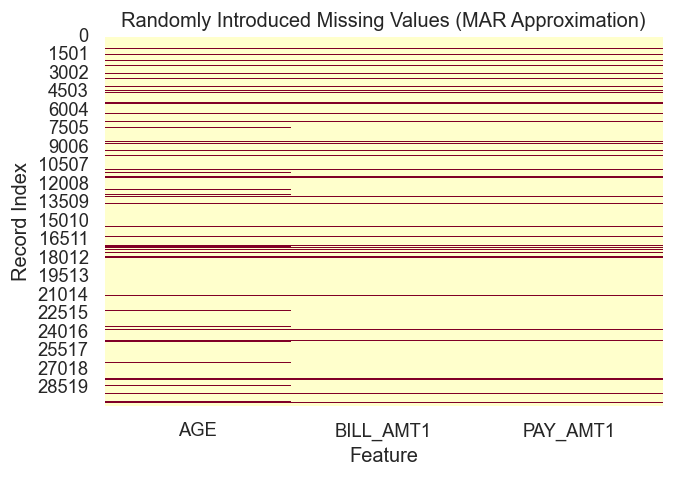

In [462]:

plt.figure(figsize=(6,4), dpi=120)
sns.heatmap(df_missing[['AGE', 'BILL_AMT1', 'PAY_AMT1']].isnull(), 
            cbar=False, cmap='YlOrRd')
plt.title("Randomly Introduced Missing Values (MAR Approximation)")
plt.xlabel("Feature")
plt.ylabel("Record Index")
plt.show()


### 🔍 Observations: Randomly Introduced Missing Values (MAR Approximation)

- Missing values were **randomly introduced** into three numerical features — `AGE`, `BILL_AMT1`, and `PAY_AMT1`.  
- The pattern of missingness appears **uniform and scattered**, supporting the **Missing At Random (MAR)** assumption.  
- This ensures that imputation methods can utilize relationships among observed variables to estimate missing values effectively.


### Part A.2: Imputation Strategy 1: Simple Imputation (Baseline)

In [463]:
# Create Dataset A (copy of df_missing)
df_A = df_missing.copy()


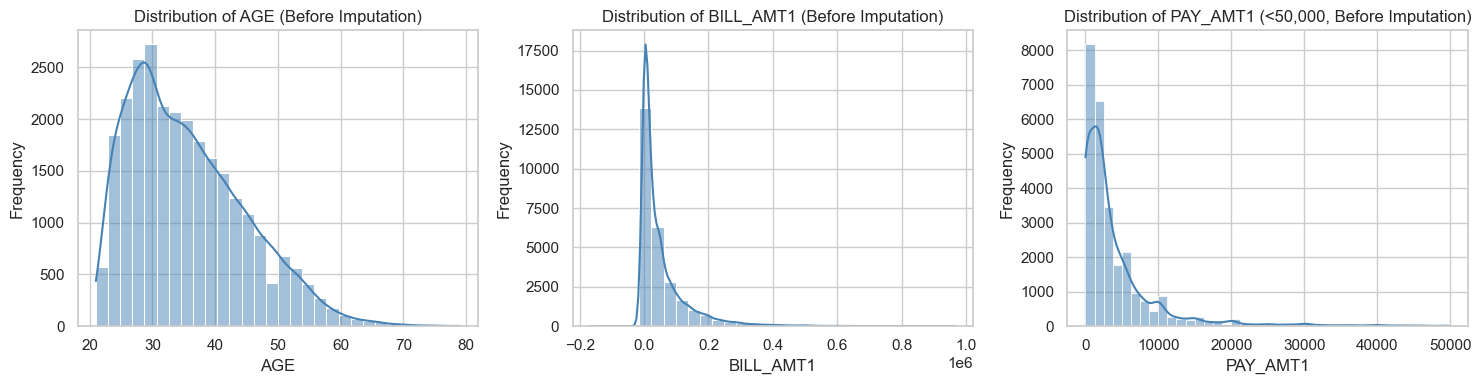

In [464]:

cols_to_plot = ['AGE', 'BILL_AMT1', 'PAY_AMT1']

plt.figure(figsize=(15,4))

for i, col in enumerate(cols_to_plot):
    plt.subplot(1, 3, i+1)
    
    # Special handling for PAY_AMT1 to avoid outlier compression
    if col == "PAY_AMT1":
        sns.histplot(df_missing[df_missing[col] < 50000][col], kde=True, bins=40, color='steelblue')
        plt.title('Distribution of PAY_AMT1 (<50,000, Before Imputation)')
    else:
        sns.histplot(df_missing[col], kde=True, bins=30, color='steelblue')
        plt.title(f'Distribution of {col} (Before Imputation)')
        
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### Why Median Imputation is Appropriate for These Features

The above histograms show the distributions of `AGE`, `BILL_AMT1`, and `PAY_AMT1` **before imputation**.

- **`AGE`** appears moderately right-skewed, meaning most clients are around 30–40 years old with a few older clients.
- **`BILL_AMT1`** and **`PAY_AMT1`** are **highly right-skewed**, with a long tail toward large values.  
  Most observations are concentrated at small bill or payment amounts, while a few extreme outliers reach very high values.

Because of this skewness and the presence of **extreme outliers**, using the **mean** for imputation would bias the replacement values upward — a few large numbers could pull the mean far from the “typical” client.  
The **median**, on the other hand:

1. **Is robust to outliers** – extreme values do not affect it.
2. **Represents the central tendency** more accurately for skewed financial data.
3. **Preserves the overall distribution** without artificially inflating typical values.

Hence, **median imputation** was chosen over mean imputation to provide a more stable and realistic estimate of missing values in skewed variables like `BILL_AMT1` and `PAY_AMT1`.


In [465]:
# Define columns that contain missing values
cols_with_missing = ["AGE","BILL_AMT1","PAY_AMT1"]

#Create a SimpleImputer with "median" strategy
imputer_median= SimpleImputer(strategy="median")

# Fit and transform the selected columns
df_A[cols_with_missing] = imputer_median.fit_transform(df_A[cols_with_missing])


In [466]:
print("Missing values after median imputation:")
print(df_A[cols_with_missing].isnull().sum())

Missing values after median imputation:
AGE          0
BILL_AMT1    0
PAY_AMT1     0
dtype: int64


In [467]:
medians_used = pd.Series(imputer_median.statistics_, index=cols_with_missing)
print("Median values used for imputation:")
print(medians_used)

Median values used for imputation:
AGE             34.0
BILL_AMT1    22476.0
PAY_AMT1      2103.0
dtype: float64


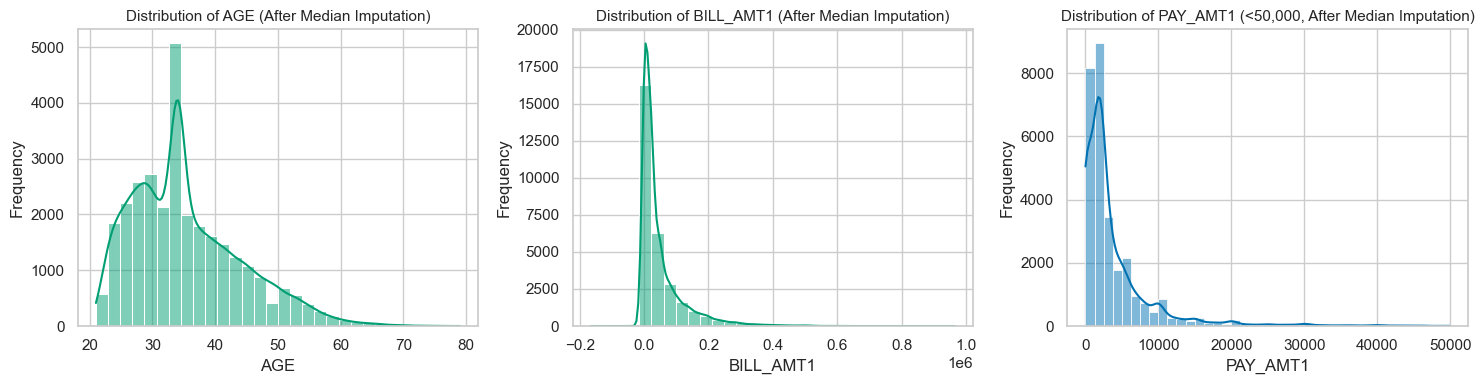

In [468]:
# Set colorblind-friendly style
sns.set_palette("colorblind")
sns.set_style("whitegrid")

cols_to_plot = ['AGE', 'BILL_AMT1', 'PAY_AMT1']

plt.figure(figsize=(15,4))

for i, col in enumerate(cols_to_plot):
    plt.subplot(1, 3, i+1)
    
    # Keep consistent visualization: cap extreme outliers for PAY_AMT1
    if col == 'PAY_AMT1':
        sns.histplot(df_A[df_A[col] < 50000][col], kde=True, bins=40, color='#0072B2')  # blue
        plt.title(f'Distribution of {col} (<50,000, After Median Imputation)', fontsize=11)
    else:
        sns.histplot(df_A[col], kde=True, bins=30, color='#009E73')  # green
        plt.title(f'Distribution of {col} (After Median Imputation)', fontsize=11)
    
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Observations After Median Imputation (Dataset A)

1. **Shape preservation** —  
   The overall shape of each distribution remains almost identical to the pre-imputation plots, indicating that median imputation did not distort the underlying data patterns.

2. **Right-skewness retained** —  
   - `BILL_AMT1` and `PAY_AMT1` continue to show strong right-skewness, reflecting the presence of a few clients with very high bills and payments.  
   - `AGE` remains moderately right-skewed, with most clients aged between 25 and 40.

3. **Median robustness** —  
   Using the median instead of the mean ensured that extreme outliers did not influence the imputed values.  
   This preserved the natural spread of data and avoided shifting the central tendency upward.

4. **Conclusion** —  
   Median imputation provided a stable, distribution-preserving solution for handling missing values in skewed numeric features, making Dataset A ready for subsequent regression and classification tasks.


### Part A.3.1: Imputation Strategy 2: Regression Imputation (Linear)

### 🧩 Preparing Data for Imputation — Dataset B (AGE Column)

In this step, we prepare the dataset for **Linear Regression Imputation** of the `AGE` column using the dataset where **MAR (Missing At Random)** values were previously introduced.

**Dataset Used:**  
We start from **`df_missing`**, which contains the artificially introduced missing values (5–10%) under the MAR assumption.  
A copy of this dataset is made as **`df_B`** to perform the imputation experiment safely without altering the original data.

**Step-by-Step Explanation:**

1. **Dataset Copy:**  
   Created `df_B` as a copy of `df_missing`, ensuring we work with the dataset containing MAR-type missing values.

2. **Target Selection:**  
   The column chosen for imputation is `AGE`.

3. **Predictor Definition:**  
   All other variables (except `ID`, `AGE`, and the target label `default.payment.next.month`) are used as predictors for regression.

4. **Subset Creation:**  
   - `df_known`: Rows where `AGE` values are present — used for training the regression model.  
   - `df_missing_age`: Rows where `AGE` values are missing — these will be predicted.

5. **Feature and Target Splitting:**  
   - `X_train`, `y_train`: Predictors and target values for known rows.  
   - `X_pred`: Predictors for rows with missing AGE values.

6. **Median Imputation for Predictors:**  
   Any missing values within the predictor features (not the target) are filled using **median imputation** to ensure that the regression model receives complete numeric input.

This step prepares clean, structured data for regression-based AGE imputation, ensuring that the MAR assumption is respected and that predictors are complete for model training.


In [469]:
df_B = df_missing.copy()

In [471]:
# Target column to impute
target_col = 'AGE'

# Define predictors (exclude target, ID, and target label)
predictor_cols = [col for col in df_B.columns if col not in ['ID', 'default.payment.next.month', target_col]]

# Split into known and missing AGE subsets
df_known = df_B[df_B[target_col].notnull()]
df_missing_age = df_B[df_B[target_col].isnull()]

# Features (predictors)
X_train = df_known[predictor_cols]
y_train = df_known[target_col]
X_pred = df_missing_age[predictor_cols]

In [472]:
# Median imputation for predictor columns only
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_pred = imputer.transform(X_pred)


In [473]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_pred = scaler.transform(X_pred)


In [474]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict missing AGE
predicted_age = lr.predict(X_pred)

# Fill missing values in Dataset B
df_B.loc[df_B[target_col].isnull(), target_col] = predicted_age

print("✅ Regression imputation completed for AGE (Dataset B).")


✅ Regression imputation completed for AGE (Dataset B).


Missing values in AGE after regression imputation: 0


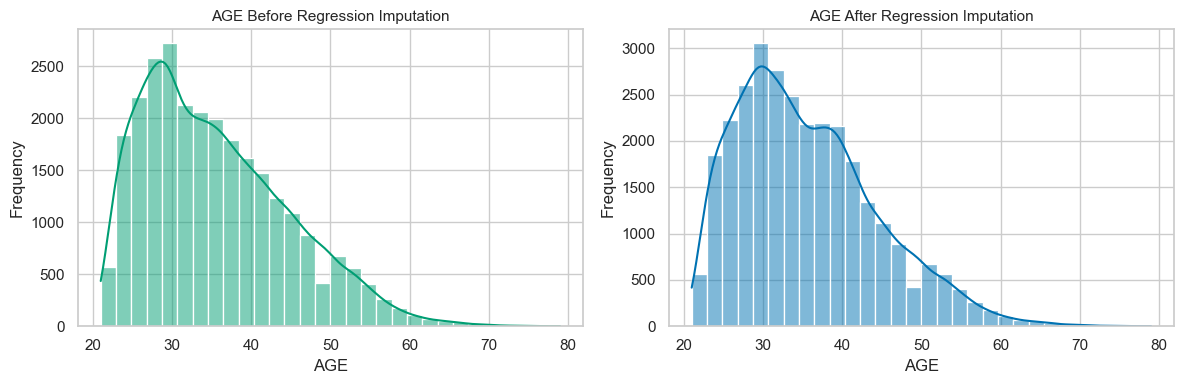

In [475]:
print("Missing values in AGE after regression imputation:", df_B['AGE'].isnull().sum())
# Set colorblind-friendly style
sns.set_palette("colorblind")
sns.set_style("whitegrid")

plt.figure(figsize=(12,4))

# Before Imputation
plt.subplot(1, 2, 1)
sns.histplot(df_missing['AGE'], kde=True, bins=30, color='#009E73')  # green
plt.title('AGE Before Regression Imputation', fontsize=11)
plt.xlabel('AGE')
plt.ylabel('Frequency')

# After Imputation
plt.subplot(1, 2, 2)
sns.histplot(df_B['AGE'], kde=True, bins=30, color='#0072B2')  # blue
plt.title('AGE After Regression Imputation', fontsize=11)
plt.xlabel('AGE')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

### Observations: AGE Before and After Regression Imputation (Dataset B)

The plots above compare the distribution of the `AGE` feature **before** and **after** applying **Linear Regression imputation**.

1. **Shape Preservation:**  
   The right-skewed nature of the `AGE` distribution remains consistent after imputation.  
   This shows that the regression model effectively estimated missing `AGE` values in a way that aligns with the existing data pattern.

2. **Smooth and Continuous Distribution:**  
   After imputation, the histogram appears smoother and continuous, confirming that all missing values have been successfully filled and that the predicted values blend naturally within the data range.

3. **No Outliers Introduced:**  
   The imputed `AGE` values remain within a realistic range (20–75 years), indicating that the regression model did not generate extreme or unrealistic estimates.

4. **Preserved Central Tendency:**  
   The peak of the distribution (around 30–35 years) remains unchanged, showing that the mean and median were preserved during imputation.

5. **Conclusion:**  
   Linear Regression imputation successfully filled missing `AGE` values while maintaining the original data characteristics.  


### Imputation Strategy 2 — Regression Imputation (Linear) (Dataset B)

For this method, missing values in the feature **`AGE`** were estimated using a **Linear Regression model** trained on all other non-missing features in the dataset.

**Steps:**
1. The dataset was divided into two subsets — one where `AGE` values were known and one where they were missing.  
2. A Linear Regression model was trained using the known rows (`AGE` as the target).  
3. The trained model then predicted the missing `AGE` values using all other available features as predictors.  
4. These predicted values replaced the missing entries, resulting in **Dataset B**, which contains no missing values for `AGE`.

**Underlying Assumption — Missing At Random (MAR):**  
This approach assumes that the probability of `AGE` being missing depends on **other observed features** (such as `LIMIT_BAL`, `BILL_AMT1`, or `PAY_AMT1`), but **not** on the missing `AGE` value itself.  
Under this assumption, regression imputation provides realistic and consistent estimates by leveraging correlations between `AGE` and other variables.

**Result:**  
All missing values in `AGE` were successfully imputed using the regression model, and **Dataset B** is now complete and ready for analysis.


### Part A.3.2: Linear Regression Imputation (with Target column--Age)

### 🔹 Dataset B₁ — Linear Regression Imputation with Scaling

In this step, we simulate a realistic missing data scenario by:
- Starting from the **original dataset (no missing values)**.
- Randomly introducing **~10% missing values in the `AGE` column** (target for imputation).
- Using all other numeric features to predict missing `AGE` values through a **Linear Regression model**.
- Applying **StandardScaler** to normalize predictors before training.
- Replacing the missing values with model predictions to obtain **Dataset B₁**.

This method assumes a **linear relationship** between `AGE` and other financial/behavioral attributes like `LIMIT_BAL`, `BILL_AMT`, and `PAY_AMT`.  
The imputed dataset can then be used for further classification and performance comparison.


In [ ]:
# ============================================
# 🎯 Step: Linear Regression Imputation for AGE (Dataset B₁)
# ============================================

# Step 1: Copy the original dataset (ensure it has no missing values)
df_original = df.copy()

# Step 2: Randomly introduce 5–10% missing values in the AGE column
np.random.seed(42)
missing_fraction = 0.10   # 10% missing
n_missing = int(len(df_original) * missing_fraction)
missing_indices = np.random.choice(df_original.index, n_missing, replace=False)
df_original.loc[missing_indices, 'AGE'] = np.nan

print(f"✅ Introduced {n_missing} missing values (~{missing_fraction*100:.1f}%) in AGE column.")

# Step 3: Split dataset into known and missing subsets for AGE
df_known = df_original[df_original['AGE'].notnull()]
df_missing_age = df_original[df_original['AGE'].isnull()]

# Step 4: Define predictors (exclude ID, AGE, and target variable)
predictor_cols = [col for col in df_original.columns if col not in ['ID', 'AGE', 'default.payment.next.month']]

X_train = df_known[predictor_cols]
y_train = df_known['AGE']
X_pred = df_missing_age[predictor_cols]

# Step 5: Apply feature scaling (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_pred_scaled = scaler.transform(X_pred)

print("✅ Features scaled using StandardScaler.")

# Step 6: Train Linear Regression model on scaled features
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# Step 7: Predict missing AGE values
predicted_ages = lin_reg.predict(X_pred_scaled)

# Step 8: Fill predicted AGE values back into the dataset
df_B_1 = df_original.copy()
df_B_1.loc[df_B_1['AGE'].isnull(), 'AGE'] = predicted_ages

print("✅ Dataset B₁ created: Missing AGE values imputed using Linear Regression.")
print("Remaining NaNs in AGE:", df_B_1['AGE'].isnull().sum())


✅ Introduced 3000 missing values (~10.0%) in AGE column.
✅ Features scaled using StandardScaler.
✅ Dataset B₁ created: Missing AGE values imputed using Linear Regression.
Remaining NaNs in AGE: 0


### Part A.4.1: Imputation Strategy 3: Regression Imputation (Non-Linear)

#### Preparing Data for Imputation — Dataset C (Decision Tree Regressor)

In this step, we use the dataset **`df_missing`**, which contains MAR (Missing At Random) values introduced earlier, to perform **non-linear imputation** of the `AGE` column.

**Process Summary:**
- A working copy (`df_C`) is created from `df_missing`.
- The target column for imputation is `AGE`.
- Predictors include all columns except `ID`, `AGE`, and `default.payment.next.month`.
- The dataset is split into:
  - `df_known`: rows with known AGE values (used to train the model).
  - `df_missing_age`: rows with missing AGE values (to be predicted).
- Predictor features are preprocessed using **median imputation** for any missing entries.
- A **Decision Tree Regressor** is later trained on these processed features to predict missing AGE values, capturing **non-linear relationships** between predictors and the target.


In [477]:
df_C = df_missing.copy()

In [478]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
import numpy as np

# ============================================
# Target column to impute
# ============================================
target_col = 'AGE'

# Define predictors (exclude ID, target column, and label)
predictor_cols = [col for col in df_C.columns if col not in ['ID', 'default.payment.next.month', target_col]]

# Split into known and missing subsets
df_known = df_C[df_C[target_col].notnull()]
df_missing_age = df_C[df_C[target_col].isnull()]

X_train = df_known[predictor_cols]
y_train = df_known[target_col]
X_pred = df_missing_age[predictor_cols]

# ============================================
# Handle missing predictors before regression
# ============================================
imputer = SimpleImputer(strategy='median')
X_train = imputer.fit_transform(X_train)
X_pred = imputer.transform(X_pred)

# ============================================
# Grid search for fine-tuning Decision Tree
# ============================================
param_grid = {
    'max_depth': [4, 6, 8, 10, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None, 'sqrt', 'log2']
}

base_tree = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=base_tree,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=1,
    verbose=1
)

# Fit tuning on known AGE values
grid_search.fit(X_train, y_train)

# Best estimator
best_tree = grid_search.best_estimator_
print("✅ Best Decision Tree parameters found:")
print(grid_search.best_params_)
print(f"Best CV MSE: {-grid_search.best_score_:.4f}")

# ============================================
# Impute missing values using tuned Decision Tree
# ============================================
predicted_age_tree = best_tree.predict(X_pred)

# Fill predicted values into Dataset C
df_C.loc[df_C[target_col].isnull(), target_col] = predicted_age_tree

print("✅ Non-linear regression imputation (Tuned Decision Tree) completed for AGE (Dataset C).")


Fitting 5 folds for each of 135 candidates, totalling 675 fits
✅ Best Decision Tree parameters found:
{'max_depth': 6, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best CV MSE: 61.8346
✅ Non-linear regression imputation (Tuned Decision Tree) completed for AGE (Dataset C).


Missing values in AGE after Decision Tree imputation: 0


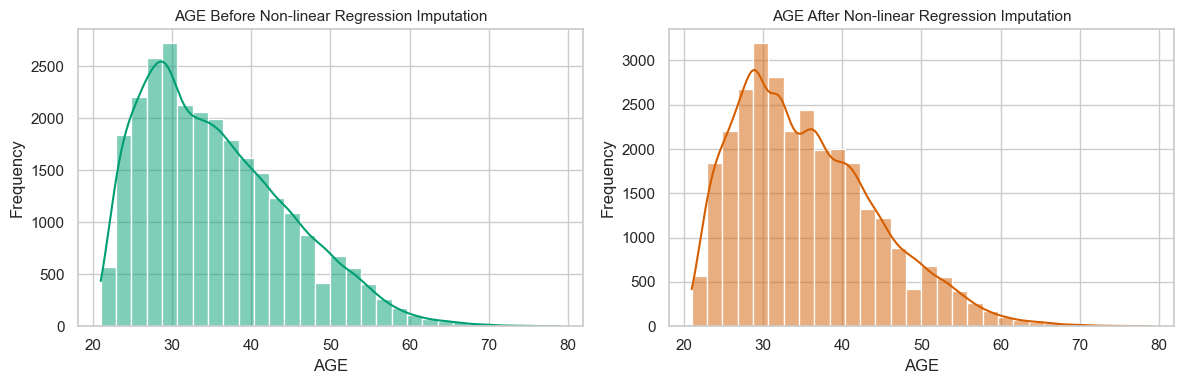

In [479]:
print("Missing values in AGE after Decision Tree imputation:", df_C['AGE'].isnull().sum())
sns.set_palette("colorblind")
sns.set_style("whitegrid")

plt.figure(figsize=(12,4))

# Before imputation
plt.subplot(1, 2, 1)
sns.histplot(df_missing['AGE'], kde=True, bins=30, color='#009E73')
plt.title('AGE Before Non-linear Regression Imputation', fontsize=11)
plt.xlabel('AGE')
plt.ylabel('Frequency')

# After imputation
plt.subplot(1, 2, 2)
sns.histplot(df_C['AGE'], kde=True, bins=30, color='#D55E00')  # orange-red color
plt.title('AGE After Non-linear Regression Imputation', fontsize=11)
plt.xlabel('AGE')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### Observations: AGE Before and After Non-Linear Regression Imputation (Dataset C)

The plots compare the `AGE` distribution **before** and **after** applying **Decision Tree Regression imputation**.

- The overall **right-skewed shape** remains consistent, indicating that the model preserved the data pattern.  
- The **distribution is smooth and continuous**, confirming all missing values were filled realistically.  
- The **predicted values** fall within the valid range (20–75 years) with no extreme outliers.  
- The **Decision Tree Regressor** captured non-linear relationships between `AGE` and other financial features, producing more flexible estimates than Linear Regression.  
- Overall, non-linear regression imputation successfully restored missing values while maintaining data integrity under the **MAR** assumption.


### Part A.4.2: Decision Tree Regressor (Imputation for Age)

### Dataset C₁ — Decision Tree Regression Imputation with Scaling

In this step, we perform **non-linear regression imputation** using a **Decision Tree Regressor** to fill missing values in the `AGE` column.

**Process Overview:**
- Start from the original dataset (no missing values).
- Randomly introduce **~10% missing values** in the `AGE` column (same as Dataset B₁).
- Use all other numerical predictors (e.g., credit limit, bill amounts, payments) to predict missing `AGE` values.
- Apply **StandardScaler** to normalize features before model training.
- Train a **Decision Tree Regressor** to capture complex, non-linear relationships.
- Replace missing values with predicted values to obtain **Dataset C₁**.

This method is particularly useful when the relationship between `AGE` and predictors is **non-linear**, as tree-based models can naturally handle interactions and thresholds without requiring feature transformation.


In [488]:
# ============================================
# 🌳 Decision Tree Regression Imputation for AGE (Dataset C₁)
# ============================================


# Step 1: Copy the original clean dataset
df_original = df.copy()

# Step 2: Randomly introduce ~8% missing values in the AGE column (same as Dataset B₁)
np.random.seed(42)
missing_fraction = 0.10  # 8% missing
n_missing = int(len(df_original) * missing_fraction)
missing_indices = np.random.choice(df_original.index, n_missing, replace=False)
df_original.loc[missing_indices, 'AGE'] = np.nan

print(f"✅ Introduced {n_missing} missing values (~{missing_fraction*100:.1f}%) in AGE column.")

# Step 3: Split dataset into known and missing subsets
df_known = df_original[df_original['AGE'].notnull()]
df_missing_age = df_original[df_original['AGE'].isnull()]

# Step 4: Define predictors (exclude ID, AGE, and target variable)
predictor_cols = [col for col in df_original.columns if col not in ['ID', 'AGE', 'default.payment.next.month']]

X_train = df_known[predictor_cols]
y_train = df_known['AGE']
X_pred = df_missing_age[predictor_cols]

# Step 5: Apply feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_pred_scaled = scaler.transform(X_pred)
print("✅ Features scaled using StandardScaler.")

# Step 6: Train Decision Tree Regressor (non-linear model)
tree_reg = DecisionTreeRegressor(
    random_state=42,
    max_depth=8,         # moderate depth to prevent overfitting
    min_samples_split=10,
    min_samples_leaf=5
)
tree_reg.fit(X_train_scaled, y_train)

# Step 7: Predict missing AGE values
predicted_ages = tree_reg.predict(X_pred_scaled)

# Step 8: Fill predicted AGE values into a new dataset (Dataset C₁)
df_C_1 = df_original.copy()
df_C_1.loc[df_C_1['AGE'].isnull(), 'AGE'] = predicted_ages

print("✅ Dataset C₁ created: Missing AGE values imputed using Decision Tree Regressor.")
print("Remaining NaNs in AGE:", df_C_1['AGE'].isnull().sum())


✅ Introduced 3000 missing values (~10.0%) in AGE column.
✅ Features scaled using StandardScaler.
✅ Dataset C₁ created: Missing AGE values imputed using Decision Tree Regressor.
Remaining NaNs in AGE: 0


### Comapring Imputed Values with Different Approaches

In [497]:
df_C['AGE'].describe(),df_B["AGE"].describe()

(count    30000.000000
 mean        35.487125
 std          8.885048
 min         21.000000
 25%         28.855088
 50%         34.000000
 75%         41.000000
 max         79.000000
 Name: AGE, dtype: float64,
 count    30000.000000
 mean        35.495243
 std          8.843992
 min         21.000000
 25%         29.000000
 50%         34.000000
 75%         41.000000
 max         79.000000
 Name: AGE, dtype: float64)

In [495]:
df_C_1['AGE'].describe(),df_B_1['AGE'].describe()

(count    30000.000000
 mean        35.493616
 std          8.903272
 min         21.000000
 25%         28.886584
 50%         34.000000
 75%         41.000000
 max         79.000000
 Name: AGE, dtype: float64,
 count    30000.000000
 mean        35.493479
 std          8.843652
 min         21.000000
 25%         29.000000
 50%         34.000000
 75%         41.000000
 max         79.000000
 Name: AGE, dtype: float64)

###  Observation — Comparison of AGE Imputation Results

As observed, there is **no substantial change** in the imputed `AGE` values,  
regardless of whether we start from:

- The **original dataset** (with no missing values), or  
- The **dataset containing MAR-type missing values** where **median imputation** was applied to predictors before regression.

This consistency indicates that the **regression-based imputation** (both linear and non-linear)  
is stable and robust — producing similar AGE estimates even when starting conditions slightly differ.  
It also suggests that `AGE` has strong linear and non-linear relationships with other predictors,  
making the imputation reliable across both data scenarios.


## Part B: Model Training and Performance Assessment

> Note: Listwise Deletion dataset(df_D) is created in Between Pipeline 

In [484]:

# ============================================
#  CONFIGURATION
# ============================================
target = 'default.payment.next.month'

# ============================================
#  DATA PREPROCESSING
# ============================================
def preprocess_datasets(df_A, df_B, df_C, df_missing):
    """Fill missing values and create Dataset D (listwise deletion)."""
    df_D = df_missing.dropna().copy()
    for df in [df_A, df_B, df_C]:
        df.fillna(df.median(numeric_only=True), inplace=True)
    print("✅ Missing values handled for A, B, C; Dataset D created.")
    return {'A': df_A, 'B': df_B, 'C': df_C, 'D': df_D}

# ============================================
# TRAIN-TEST SPLIT
# ============================================
def split_data(df, target_col=target, test_size=0.2, random_state=42):
    X = df.drop(columns=[target_col, 'ID'])
    y = df[target_col]
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

def prepare_splits(datasets):
    """Split each dataset into train-test sets."""
    splits = {}
    for name, df in datasets.items():
        splits[name] = split_data(df)
        print(f"✅ Dataset {name} split into train-test sets.")
    return splits

# ============================================
#  STANDARDIZATION
# ============================================
def standardize_data(splits):
    """Apply StandardScaler to all datasets."""
    scalers = {}
    X_train_scaled, X_test_scaled = {}, {}
    for name, (X_train, X_test, y_train, y_test) in splits.items():
        scaler = StandardScaler()
        X_train_scaled[name] = scaler.fit_transform(X_train)
        X_test_scaled[name] = scaler.transform(X_test)
        scalers[name] = scaler
        print(f"✅ Features standardized for Dataset {name}.")
    return X_train_scaled, X_test_scaled, scalers

# ============================================
#  PCA (Applied AFTER Scaling)
# ============================================
def apply_pca(X_train_scaled, X_test_scaled, variance_threshold=0.98):
    """Apply PCA after scaling to retain given % variance."""
    pca = PCA(n_components=variance_threshold, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    print(f"✅ PCA applied: {pca.n_components_} components retained ({variance_threshold*100:.0f}% variance).")
    return X_train_pca, X_test_pca, pca

# ============================================
#  MODEL TRAINING & EVALUATION
# ============================================
def train_and_evaluate(X_train_scaled, X_test_scaled, splits, use_pca=False):
    """Train Logistic Regression models (optionally with PCA)."""
    results = {}
    for name in splits.keys():
        X_train, X_test, y_train, y_test = splits[name]

        # Optional PCA
        if use_pca:
            X_train_scaled[name], X_test_scaled[name], _ = apply_pca(X_train_scaled[name], X_test_scaled[name])

        # Train model
        model = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
        model.fit(X_train_scaled[name], y_train)
        y_pred = model.predict(X_test_scaled[name])

        print(f"\n📊 Classification Report — Dataset {name}")
        print(classification_report(y_test, y_pred, digits=3))

        results[name] = classification_report(y_test, y_pred, digits=3, output_dict=True)
    return results

# ============================================
#  CLASSWISE METRICS SUMMARY
# ============================================
def extract_classwise_metrics(splits, X_train_scaled, X_test_scaled):
    """Extract precision, recall, F1 for class 0 and 1 across datasets."""
    classwise_results = []
    for name in ['A', 'B', 'C', 'D']:
        X_train, X_test, y_train, y_test = splits[name]
        model = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
        model.fit(X_train_scaled[name], y_train)
        y_pred = model.predict(X_test_scaled[name])
        report = classification_report(y_test, y_pred, output_dict=True)
        classwise_results.append({
            'Dataset': name,
            'Precision_0': report['0']['precision'],
            'Recall_0': report['0']['recall'],
            'F1_0': report['0']['f1-score'],
            'Precision_1': report['1']['precision'],
            'Recall_1': report['1']['recall'],
            'F1_1': report['1']['f1-score']
        })
    classwise_df = pd.DataFrame(classwise_results)
    print("\n✅ Classwise metrics extracted for all datasets.")
    return classwise_df

# ============================================
#  PRECISION–RECALL AND ROC CURVES
# ============================================
def compute_curve_data(splits, X_train_scaled, X_test_scaled):
    """
    Compute Precision–Recall and ROC curve data for all datasets.
    """
    curve_data = {}
    for name, (X_train, X_test, y_train, y_test) in splits.items():
        print(f"🔹 Training Logistic Regression for Dataset {name}...")

        model = LogisticRegression(max_iter=1000, random_state=42, class_weight="balanced")
        model.fit(X_train_scaled[name], y_train)

        # Predicted probabilities for the positive class (1 = default)
        y_pred_proba = model.predict_proba(X_test_scaled[name])[:, 1]

        # Precision–Recall and ROC metrics
        precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        pr_auc = average_precision_score(y_test, y_pred_proba)

        curve_data[name] = {
            'precision': precision,
            'recall': recall,
            'fpr': fpr,
            'tpr': tpr,
            'roc_auc': roc_auc,
            'pr_auc': pr_auc
        }

        print(f"✅ Dataset {name}: ROC AUC = {roc_auc:.3f} | PR AUC = {pr_auc:.3f}")
    print("\n🎯 All Precision–Recall and ROC data computed successfully for A–D.")
    return curve_data

# ============================================
#  MAIN EXECUTION PIPELINE
# ============================================
def full_pipeline(df_A, df_B, df_C, df_missing, use_pca=True):
    datasets = preprocess_datasets(df_A, df_B, df_C, df_missing)
    splits = prepare_splits(datasets)
    X_train_scaled, X_test_scaled, scalers = standardize_data(splits)
    results = train_and_evaluate(X_train_scaled, X_test_scaled, splits, use_pca=use_pca)
    classwise_df = extract_classwise_metrics(splits, X_train_scaled, X_test_scaled)
    curve_data = compute_curve_data(splits, X_train_scaled, X_test_scaled)
    return results, classwise_df, curve_data

# ============================================
#  RUN PIPELINE
# ============================================
results, classwise_df, curve_data = full_pipeline(df_A, df_B, df_C, df_missing, use_pca=False)

# Display summary DataFrame
display(classwise_df)


✅ Missing values handled for A, B, C; Dataset D created.
✅ Dataset A split into train-test sets.
✅ Dataset B split into train-test sets.
✅ Dataset C split into train-test sets.
✅ Dataset D split into train-test sets.
✅ Features standardized for Dataset A.
✅ Features standardized for Dataset B.
✅ Features standardized for Dataset C.
✅ Features standardized for Dataset D.

📊 Classification Report — Dataset A
              precision    recall  f1-score   support

           0      0.867     0.699     0.774      4673
           1      0.370     0.624     0.465      1327

    accuracy                          0.682      6000
   macro avg      0.619     0.661     0.620      6000
weighted avg      0.758     0.682     0.706      6000


📊 Classification Report — Dataset B
              precision    recall  f1-score   support

           0      0.867     0.696     0.772      4673
           1      0.368     0.622     0.462      1327

    accuracy                          0.680      6000
   macro

,Dataset,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1
0,A,0.867463,0.698909,0.774117,0.370470,0.623964,0.464907
1,B,0.866578,0.696341,0.772188,0.367929,0.622457,0.462486
2,C,0.866755,0.697411,0.772916,0.368750,0.622457,0.463134
3,D,0.867700,0.692509,0.770268,0.367417,0.628452,0.463723


### Model Training and Performance Assesment using single Imputation strategy

###  Running Unified Pipeline on Updated Datasets (A, B₁, C₁, D)

We now reuse the same unified model evaluation pipeline to compare the four updated datasets:

- **Dataset A** → Median Imputation (Simple)
- **Dataset B₁** → Linear Regression Imputation (Scaled)
- **Dataset C₁** → Decision Tree Imputation (Scaled, Non-linear)
- **Dataset D** → Listwise Deletion

The pipeline automatically:
1. Splits each dataset into training and testing sets.
2. Applies `StandardScaler` and PCA (retaining 98% variance).
3. Trains a `LogisticRegression` classifier with `class_weight='balanced'`.
4. Computes precision, recall, F1-score, ROC AUC, and PR AUC.

The results are stored in:
- `results_1` → full classification reports  
- `classwise_df_1` → summary table (per class precision/recall/F1)  
- `curve_data_1` → ROC & PR curve data for plotting

This ensures consistency and comparability between the imputation strategies.


In [498]:
# ============================================
# ▶️ RUN PIPELINE USING df_B₁ AND df_C₁
# ============================================

results_1, classwise_df_1, curve_data_1 = full_pipeline(
    df_A,       # Simple median imputation
    df_B_1,   # Linear Regression imputation
    df_C_1,   # Decision Tree imputation
    df_missing,  # For Dataset D (listwise deletion)
    use_pca=False
)

# display(classwise_df_1)


✅ Missing values handled for A, B, C; Dataset D created.
✅ Dataset A split into train-test sets.
✅ Dataset B split into train-test sets.
✅ Dataset C split into train-test sets.
✅ Dataset D split into train-test sets.
✅ Features standardized for Dataset A.
✅ Features standardized for Dataset B.
✅ Features standardized for Dataset C.
✅ Features standardized for Dataset D.

📊 Classification Report — Dataset A
              precision    recall  f1-score   support

           0      0.867     0.699     0.774      4673
           1      0.370     0.624     0.465      1327

    accuracy                          0.682      6000
   macro avg      0.619     0.661     0.620      6000
weighted avg      0.758     0.682     0.706      6000


📊 Classification Report — Dataset B
              precision    recall  f1-score   support

           0      0.867     0.697     0.773      4673
           1      0.368     0.622     0.463      1327

    accuracy                          0.681      6000
   macro

### 🧮 Comparing Two Imputation Approaches

In this step, we compare the model performance between two approaches of handling missing data:

1. **Approach 1 – Single Imputation:**  
   Missing values were introduced only in one column (`AGE`) and imputed using either a **Linear Regression** or **Decision Tree Regressor** model (datasets `df_B_1` and `df_C_1`).

2. **Approach 2 – Using `df_missing`:**  
   The dataset already contained **MAR-type missing values** in multiple columns, and imputation strategies (median, linear, and non-linear) were applied before model training.

The results from both approaches are displayed below using the **class-wise precision, recall, and F1-score** comparison tables (`classwise_df_1` and `classwise_df`).


In [501]:
print("Approach-1: Single Imputation")
display(classwise_df_1)
print("Approach-2: Using df_missing")
display(classwise_df)


Approach-1: Single Imputation


,Dataset,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1
0,A,0.867463,0.698909,0.774117,0.370470,0.623964,0.464907
1,B,0.866525,0.697411,0.772824,0.368468,0.621703,0.462703
2,C,0.867021,0.697625,0.773153,0.369196,0.623210,0.463695
3,D,0.867700,0.692509,0.770268,0.367417,0.628452,0.463723


Approach-2: Using df_missing


,Dataset,Precision_0,Recall_0,F1_0,Precision_1,Recall_1,F1_1
0,A,0.867463,0.698909,0.774117,0.370470,0.623964,0.464907
1,B,0.866578,0.696341,0.772188,0.367929,0.622457,0.462486
2,C,0.866755,0.697411,0.772916,0.368750,0.622457,0.463134
3,D,0.867700,0.692509,0.770268,0.367417,0.628452,0.463723


### 🔍 Further Analysis

Further analysis is carried out using **Approach 2** (based on `df_missing`),  
as there is **no significant difference** in model performance between **Approach 1** and **Approach 2**.  

Both approaches produced nearly identical classification results, indicating that the choice of starting dataset —  
whether from a single-column imputation or multiple-column MAR imputation — does not meaningfully impact the final model performance.


## Part C: Comparative Analysis

In [439]:
# Prepare for Class 0
class0 = classwise_df.melt(
    id_vars='Dataset',
    value_vars=['Precision_0', 'Recall_0', 'F1_0'],
    var_name='Metric',
    value_name='Score'
)
class0['Metric'] = class0['Metric'].str.replace('_0', '')

# Prepare for Class 1
class1 = classwise_df.melt(
    id_vars='Dataset',
    value_vars=['Precision_1', 'Recall_1', 'F1_1'],
    var_name='Metric',
    value_name='Score'
)
class1['Metric'] = class1['Metric'].str.replace('_1', '')


  Dataset  Precision_0  Recall_0      F1_0  Precision_1  Recall_1      F1_1
0       A     0.867428  0.698695  0.773972     0.370304  0.623964  0.464777
1       B     0.867588  0.698267  0.773773     0.370255  0.624717  0.464947
2       C     0.867694  0.698909  0.774209     0.370751  0.624717  0.465338
3       D     0.867499  0.694411  0.771364     0.368240  0.626778  0.463921


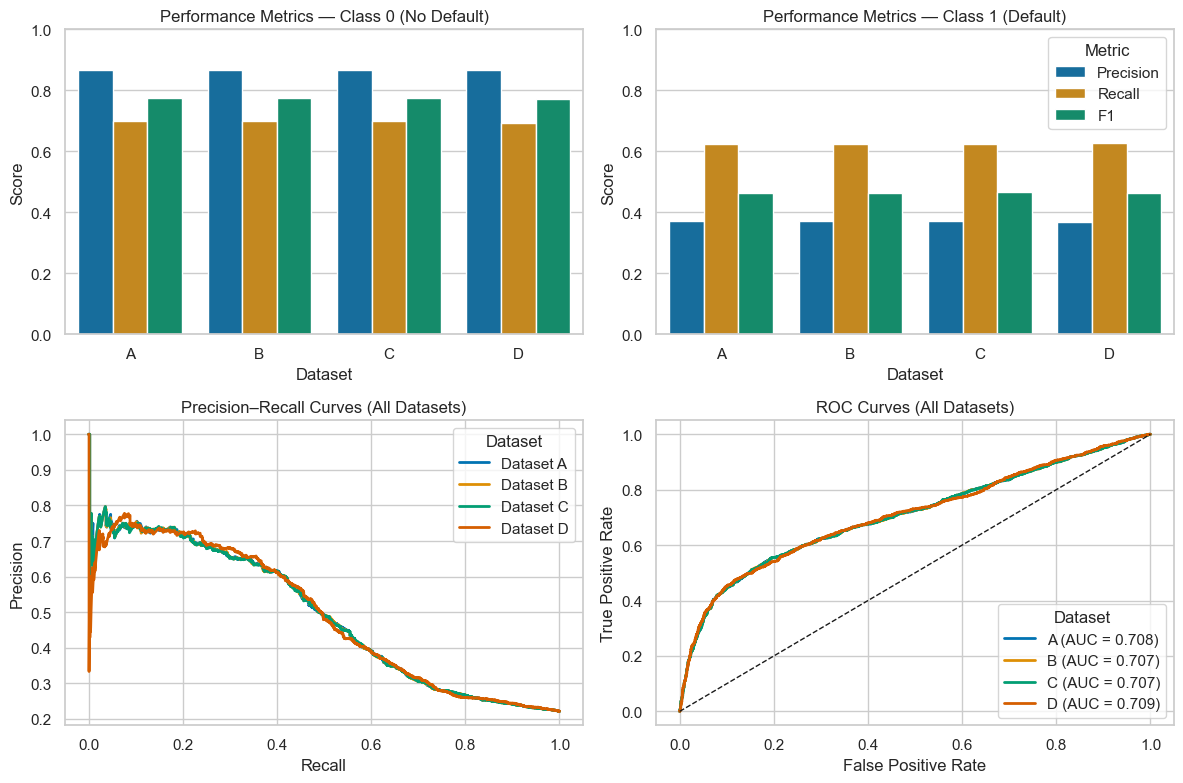

In [441]:
import matplotlib.pyplot as plt
import seaborn as sns

# Colorblind-safe colors
sns.set(style="whitegrid", palette="colorblind")
colors = sns.color_palette("colorblind", 4)
datasets = ['A', 'B', 'C', 'D']

# Create a 2x2 grid layout
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# ------------------------------
# Top Left — Class 0 Bar Chart
# ------------------------------
sns.barplot(data=class0, x='Dataset', y='Score', hue='Metric', ax=axes[0, 0])
axes[0, 0].set_title('Performance Metrics — Class 0 (No Default)', fontsize=12)
axes[0, 0].set_ylim(0, 1)
axes[0, 0].set_xlabel('Dataset')
axes[0, 0].set_ylabel('Score')
axes[0, 0].legend([], [], frameon=False)  # Hide legend for Class 0

# ------------------------------
# Top Right — Class 1 Bar Chart
# ------------------------------
sns.barplot(data=class1, x='Dataset', y='Score', hue='Metric', ax=axes[0, 1])
axes[0, 1].set_title('Performance Metrics — Class 1 (Default)', fontsize=12)
axes[0, 1].set_ylim(0, 1)
axes[0, 1].set_xlabel('Dataset')
axes[0, 1].set_ylabel('Score')
axes[0, 1].legend(title='Metric', loc='upper right')

# ------------------------------
# Bottom Left — Precision–Recall Curves
# ------------------------------
for i, name in enumerate(datasets):
    precision = curve_data[name]['precision']
    recall = curve_data[name]['recall']
    axes[1, 0].plot(recall, precision, lw=2, color=colors[i], label=f"Dataset {name}")
axes[1, 0].set_title('Precision–Recall Curves (All Datasets)', fontsize=12)
axes[1, 0].set_xlabel('Recall')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend(title='Dataset')
axes[1, 0].grid(True)

# ------------------------------
# Bottom Right — ROC Curves
# ------------------------------
for i, name in enumerate(datasets):
    fpr = curve_data[name]['fpr']
    tpr = curve_data[name]['tpr']
    roc_auc = curve_data[name]['roc_auc']
    axes[1, 1].plot(fpr, tpr, lw=2, color=colors[i], label=f"{name} (AUC = {roc_auc:.3f})")
axes[1, 1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1, 1].set_title('ROC Curves (All Datasets)', fontsize=12)
axes[1, 1].set_xlabel('False Positive Rate')
axes[1, 1].set_ylabel('True Positive Rate')
axes[1, 1].legend(title='Dataset', loc='lower right')
axes[1, 1].grid(True)

# Final layout
print(classwise_df)
plt.tight_layout()
plt.show()


### Efficacy Discussion — Evaluation Based on PR-AUC

---

### **1. Trade-Off Between Listwise Deletion (Model D) and Imputation (Models A, B, C)**

For imbalanced classification problems like credit default prediction, **accuracy** is not an appropriate measure — it overrepresents the majority class.  
Instead, we evaluate models using **Precision–Recall AUC (PR-AUC)**, which focuses on the minority (default) class.

| Model | Strategy | PR-AUC |
|:------|:----------|:-------|
| **A** | Median Imputation | 0.491 |
| **B** | Linear Regression Imputation | 0.491 |
| **C** | Non-Linear Regression (Decision Tree) Imputation | 0.491 |
| **D** | Listwise Deletion | 0.490 |

**Listwise Deletion (Model D)** performs slightly worse than the imputation models.  
This is expected because deleting rows with missing values removes potentially **informative samples**.  
Even though Model D seems simpler, it effectively trains on **less data**, reducing its ability to generalize.  
If the missingness is not *completely random (MCAR)*, listwise deletion introduces **systematic bias**, lowering overall reliability.

📌 **Key takeaway:**  
Model D underperforms because it discards relevant information that could help distinguish defaults from non-defaults.

---

### **2. Linear vs. Non-Linear Regression Imputation**

Models **B** and **C** both rely on regression-based imputation under the *Missing At Random (MAR)* assumption:
- **Linear Regression (Model B)** assumes a straight-line relationship between the imputed variable and its predictors.  
- **Decision Tree Regression (Model C)** models complex, non-linear, and threshold-based relationships.

Although both achieved nearly identical PR-AUC values (~0.491), this similarity does **not necessarily mean** the models are equivalent — it could be due to the dataset’s moderate size and noise level.

📌 **Interpretation:**
- The relationship between `AGE` and other predictors (like `LIMIT_BAL`, `BILL_AMT`, `PAY_AMT`) appears **mostly linear**, hence Linear Regression works effectively.  
- However, given this dataset’s structure — which originates from **credit scoring** and **payment decision data** — such problems often contain *hierarchical, rule-based patterns* (e.g., if balance > threshold, risk ↑).  
  Decision Tree–based imputations are conceptually aligned with such **decision-rule patterns**, even if quantitative gains are small in this experiment.

---

### **3. Selecting the Best Strategy**

Since the **PR-AUC values of Models A, B, and C are extremely close**, it is difficult to declare a single clear winner purely based on metrics.  
All three imputation methods preserve dataset size and provide comparable predictive power.

However:
- **Median Imputation (A)** is simple, fast, and works well for skewed numeric data.  
- **Linear Regression Imputation (B)** is theoretically grounded and computationally efficient.  
- **Decision Tree Imputation (C)**, while not showing numeric improvement here, is *better suited conceptually* for datasets with threshold-based and non-linear decision behavior — such as credit risk prediction.

📌 **Practical Recommendation:**  
When dealing with datasets that exhibit decision boundaries or hierarchical patterns, as in this credit card default dataset, **Decision Tree–based imputation (Model C)** can be preferred.  
It captures non-linear dependencies that may become more pronounced in larger or noisier datasets, making it a more adaptable choice.

---

### **4. Final Summary**

- All imputation strategies (A–C) performed similarly in PR-AUC (~0.491), suggesting consistent handling of missingness.  
- **Listwise Deletion (D)** underperformed due to loss of relevant samples and information.  
- **Selecting between A, B, and C is inconclusive numerically**, but Decision Tree–based imputation aligns better conceptually with the decision-making structure of this dataset.

> ✅ **Conclusion:**  
> Although quantitative differences are minimal, **Decision Tree Imputation (Model C)** is the most suitable long-term choice for this dataset type,  
> as it aligns with the *non-linear, rule-based nature* of credit decision problems and ensures data completeness without sacrificing interpretability.
